In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision import transforms
from torch.utils.data import DataLoader
from matplotlib.colors import LinearSegmentedColormap

# Get the absolute path to the project root directory (parent of both notebooks and src)
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
project_src = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../src'))
sys.path.append(project_root)
sys.path.append(project_src)

from src.point_based_unet_v2 import PointPromptedUNet, PointPromptedPetDataset

Using device: cpu


In [2]:
def load_model(model_path, num_classes=3):
    """Load a trained PointPromptedUNet model."""
    # Initialize model (adjust parameters as needed)
    model = PointPromptedUNet(
        in_channels=3,
        out_channels=num_classes,
        features_start=32,
        point_encoder_type='parallel'  # Change to 'parallel' if that's what was used
    )
    
    # Load weights
    checkpoint = torch.load(model_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()
    
    return model

def predict_with_model(model, image, fg_heatmap, bg_heatmap, device='cpu'):
    """
    Predict segmentation mask using the model and point heatmaps.
    
    Args:
        model: PointPromptedUNet model
        image (torch.Tensor): Image tensor of shape (C, H, W)
        fg_heatmap (torch.Tensor): Foreground heatmap tensor
        bg_heatmap (torch.Tensor): Background heatmap tensor
        device: Device to run inference on
        
    Returns:
        torch.Tensor: Predicted segmentation mask
    """
    model.eval()
    
    # Add batch dimension if needed
    if image.dim() == 3:
        image = image.unsqueeze(0)
    
    # Ensure heatmaps have batch dimension
    if fg_heatmap.dim() == 2:
        fg_heatmap = fg_heatmap.unsqueeze(0)
    if bg_heatmap.dim() == 2:
        bg_heatmap = bg_heatmap.unsqueeze(0)
    
    # Move to device
    image = image.to(device)
    fg_heatmap = fg_heatmap.to(device)
    bg_heatmap = bg_heatmap.to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(image, fg_heatmap, bg_heatmap)
        _, predicted = torch.max(output, 1)
    
    return predicted[0].cpu()

In [5]:
def visualize_test_samples(model, test_loader, device, num_samples=3, seed=2025):
    """
    Visualize model predictions on test dataset samples with their point prompts.
    
    Args:
        model: PointPromptedUNet model
        test_dataset: PointPromptedPetDataset instance for testing
        device: Device to run inference on
        num_samples: Number of test samples to visualize
    """
    # Set model to evaluation mode
    model.eval()
    
    # Class colors for visualization
    colors = np.array([
        [0, 0, 0],      # Background (black)
        [128, 0, 0],    # Cat (red)
        [0, 128, 0]     # Dog (green)
    ], dtype=np.uint8)
    
    # Create custom colormaps for heatmaps
    fg_cmap = LinearSegmentedColormap.from_list('fg_cmap', ['white', 'red'])
    bg_cmap = LinearSegmentedColormap.from_list('bg_cmap', ['white', 'blue'])
    
    # Create figure with subplots
    fig, axs = plt.subplots(num_samples, 2, figsize=(8, 6))
    
    # For single sample case, reshape axes to match expected dimensions
    if num_samples == 1:
        axs = axs.reshape(1, -1)
    
    for i in range(num_samples):
        # Get a test sample
        torch.manual_seed(seed)
        image, fg_heatmap, bg_heatmap, true_mask, fg_points, bg_points = next(iter(test_loader))

        # Predict mask
        pred_mask = predict_with_model(model, image, fg_heatmap, bg_heatmap, device)
        
        # Original image
        img_np = image[0].permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)
        axs[i, 0].imshow(img_np)
        axs[i, 0].set_title('Original Image')
        
        # Mark foreground and background points
        for point in fg_points:
            axs[i, 0].plot(point[1], point[0], 'ro', markersize=8)
        for point in bg_points:
            axs[i, 0].plot(point[1], point[0], 'bo', markersize=8)
        
        axs[i, 0].axis('off')
        
        # # Foreground point heatmap
        # axs[i, 1].imshow(fg_heatmap[0].squeeze().cpu().numpy(), cmap=fg_cmap)
        # axs[i, 1].set_title('Foreground Points Heatmap')
        # axs[i, 1].axis('off')
        
        # # Background point heatmap
        # axs[i, 2].imshow(bg_heatmap[0].squeeze().cpu().numpy(), cmap=bg_cmap)
        # axs[i, 2].set_title('Background Points Heatmap')
        # axs[i, 2].axis('off')
        
        # # Ground truth mask
        true_mask_np = true_mask[0].numpy()
        # mask_rgb = np.zeros((true_mask_np.shape[0], true_mask_np.shape[1], 3), dtype=np.uint8)
        # for j in range(3):  # 3 classes
        #     mask_rgb[true_mask_np == j] = colors[j]
        # # Make ignored regions white
        # mask_rgb[true_mask_np == 255] = [255, 255, 255]
        
        # axs[i, 1].imshow(mask_rgb)
        # axs[i, 1].set_title('Ground Truth Mask')
        # axs[i, 1].axis('off')
        
        # Predicted mask
        pred_np = pred_mask.numpy()
        pred_rgb = np.zeros((pred_np.shape[0], pred_np.shape[1], 3), dtype=np.uint8)
        for j in range(3):  # 3 classes
            pred_rgb[pred_np == j] = colors[j]
        # Also make ignored regions white in prediction visualization
        pred_rgb[true_mask_np == 255] = [255, 255, 255]
        
        axs[i, 1].imshow(pred_rgb)
        axs[i, 1].set_title('Predicted Mask')
        axs[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

Using device: cpu


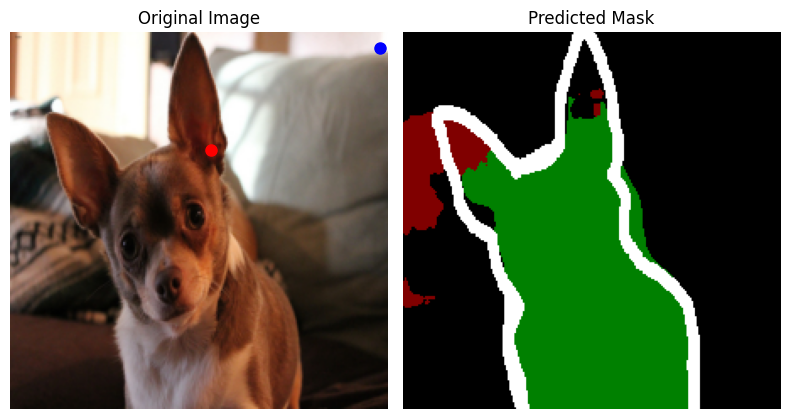

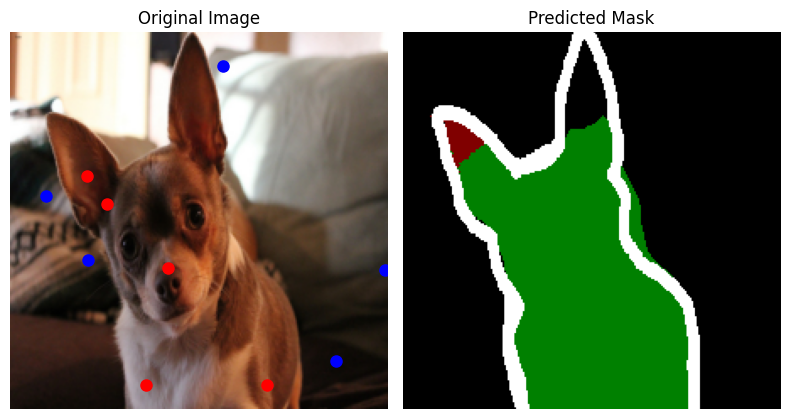

In [42]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set paths
data_root = '../Dataset_augmented/' 
model_path = '../runs/point_based_fgbg/parallel_20epochs/point_prompted_unet_pet_segmentation_best.pt' 

# Load model
model = load_model(model_path)
model.to(device)

# Create test dataset
test_dataset = PointPromptedPetDataset(
    root_dir=data_root,
    split='test',
    transform=None,  # The dataset class handles transformations internally
    num_fg_points=1,
    num_bg_points=1
)
seed = 6
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
visualize_test_samples(model, test_loader, device, num_samples=1, seed=seed)


# Create test dataset
test_dataset = PointPromptedPetDataset(
    root_dir=data_root,
    split='test',
    transform=None,  # The dataset class handles transformations internally
    num_fg_points=5,
    num_bg_points=5
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
visualize_test_samples(model, test_loader, device, num_samples=1, seed=seed)